In [1]:
!pip install pandas
!pip install numpy

In [2]:
import pandas as pd
import os
import json
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional
from matplotlib import pyplot

In [3]:
liwc_features = pd.read_csv('./LIWC2015 Results (data-kushal).csv')
liwc_features = liwc_features.drop(['Source (A)', 'Source (C)', 'Source (D)'], axis = 1)
liwc_features = liwc_features.rename(columns={'Source (B)': 'video_id'})

ids_to_use = []
with open('./video_ids_balanced.json', 'r') as f:
    ids_to_use = json.load(f)

In [4]:
# Read all the data
labels = []
labels_mapping = {}
label_count = 0
df = pd.read_csv('./raw_data.csv')

for index, row in df.iterrows():
    video_id = row['video_id']
    mod_id = video_id + '.npy'
    path = os.path.join('./processed_video', 'audio_' + video_id + '_txt')
    
    if os.path.isfile(path) and mod_id in ids_to_use:
        with open(path, 'r') as f:
            try:
                file_data = json.load(f)
                labels.append((row['video_likeCount'] - row['video_dislikeCount'])/row['video_viewCount'])
                labels_mapping[row['video_id']] = label_count
                label_count = label_count + 1
                
            except ValueError:
                print(path + ' failed processing')

labels = np.array(labels)
print()
print('Shape of labels: ', labels.shape)


Shape of labels:  (961,)


In [5]:
label_series = pd.Series(labels)
print(label_series.value_counts(bins=20).sort_index())

(-0.0010119, 0.00479]     75
(0.00479, 0.0095]        120
(0.0095, 0.0142]         104
(0.0142, 0.0189]         109
(0.0189, 0.0236]         103
(0.0236, 0.0283]         108
(0.0283, 0.033]          118
(0.033, 0.0377]           90
(0.0377, 0.0425]          62
(0.0425, 0.0472]          25
(0.0472, 0.0519]          18
(0.0519, 0.0566]          14
(0.0566, 0.0613]           5
(0.0613, 0.066]            4
(0.066, 0.0707]            2
(0.0707, 0.0754]           2
(0.0754, 0.0801]           1
(0.0801, 0.0848]           0
(0.0848, 0.0895]           0
(0.0895, 0.0942]           1
dtype: int64


In [6]:
# Prepare data for cnn lstm by concatenating frames, normalizing labels and defining constants
labels = np.clip(labels, 0.00421, 0.037)
min_label = np.min(labels)
max_label = np.max(labels)
scaled_labels = (labels - min_label)/(max_label - min_label)

In [7]:
inputs = np.zeros((961, 186, 50))

for video_id, index in labels_mapping.items():
    video_features = liwc_features.loc[liwc_features.video_id == video_id, ['compare', 'i', 'Colon', 'home', 'focuspast', 'pronoun', 'ppron', 'anx', 'Dash',
 'Sixltr', 'Analytic', 'auxverb', 'friend', 'OtherP', 'informal', 'number',
 'assent', 'WC', 'we', 'WPS', 'function', 'verb', 'negemo', 'family', 'Apostro',
 'ipron', 'feel', 'prep', 'body', 'relig', 'sexual', 'insight', 'cogproc',
 'filler', 'they', 'conj', 'leisure', 'Dic', 'netspeak', 'negate', 'focuspresent',
 'QMark', 'AllPunc', 'affiliation', 'work', 'space', 'article', 'Authentic',
 'health', 'death']].to_numpy()
    x, y = video_features.shape
    inputs[index, 0:x, :] = video_features
    del video_features, x, y

In [8]:
indices = np.arange(inputs.shape[0])
np.random.shuffle(indices)
data = inputs[indices]
labels = scaled_labels[indices]
nb_validation_samples = int(0.3 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]

x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Shape of training tensor:', x_train.shape)
print('Shape of training labels:', y_train.shape)
print('Shape of testing tensor:', x_val.shape)
print('Shape of testing labels:', y_val.shape)

Shape of training tensor: (673, 186, 50)
Shape of training labels: (673,)
Shape of testing tensor: (288, 186, 50)
Shape of testing labels: (288,)


In [9]:
input_1 = Input(shape=(186, 50), dtype='float32', name = 'input_1')
# dense_1 = TimeDistributed(Dense(186, input_shape = (186, 50) ,activation='relu'))(input_1)
lstm_1 = LSTM(1, activation='tanh', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5), activity_regularizer=l1_l2(l1=1e-5, l2=1e-5), recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-5), dropout=0.2)(input_1)
preds = Dense(1, activation='linear')(lstm_1)

model = Model(input_1, preds)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 186, 50)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
None


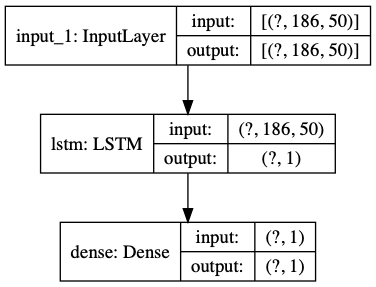

In [10]:
print(model.summary())
plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [11]:
history = model.fit(x_train, y_train, validation_split = 0.1, epochs=15, batch_size=128)

Train on 605 samples, validate on 68 samples
Epoch 1/15
605/605 [==============================] - 3s 4ms/sample - loss: 0.4007 - root_mean_squared_error: 0.6327 - val_loss: 0.3349 - val_root_mean_squared_error: 0.5783
Epoch 2/15
605/605 [==============================] - 0s 703us/sample - loss: 0.3911 - root_mean_squared_error: 0.6250 - val_loss: 0.3263 - val_root_mean_squared_error: 0.5708
Epoch 3/15
605/605 [==============================] - 0s 726us/sample - loss: 0.3816 - root_mean_squared_error: 0.6174 - val_loss: 0.3177 - val_root_mean_squared_error: 0.5633
Epoch 4/15
605/605 [==============================] - 0s 744us/sample - loss: 0.3723 - root_mean_squared_error: 0.6098 - val_loss: 0.3093 - val_root_mean_squared_error: 0.5558
Epoch 5/15
605/605 [==============================] - 0s 672us/sample - loss: 0.3630 - root_mean_squared_error: 0.6021 - val_loss: 0.3009 - val_root_mean_squared_error: 0.5482
Epoch 6/15
605/605 [==============================] - 0s 730us/sample - loss:

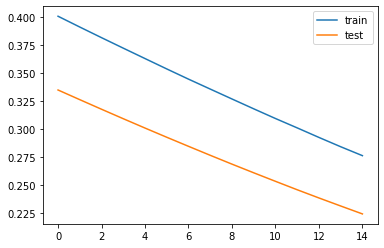

In [12]:
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [13]:
predictions = model.predict(x_val)
mse = tf.keras.losses.MeanSquaredError()
loss = mse(y_val, predictions)
print('Loss on validation set is %s' % loss.numpy())

Loss on validation set is 0.28654566


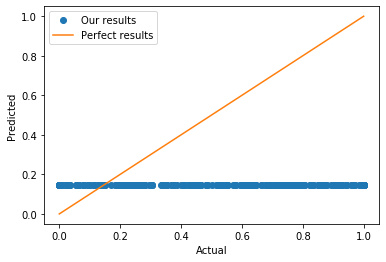

In [14]:
pyplot.plot(y_val, predictions, 'o',label="Our results")
pyplot.plot([0,1], label="Perfect results")
pyplot.xlabel("Actual")
pyplot.ylabel("Predicted")
pyplot.legend()
pyplot.savefig('liwc_model_balanced.png')

In [15]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere(y_val > 0.7))
print('Data points with score more than 0.7 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict(val_data)
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score more than 0.7 121:
Loss on validation set is 0.57577044


In [16]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere(y_val < 0.3))
print('Data points with score less than 0.3 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict(val_data)
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score less than 0.3 84:
Loss on validation set is 0.010378821


In [17]:
# More fine grained accuracy calculations
huge_score = np.squeeze(np.argwhere((y_val > 0.3) & (y_val < 0.7)))
print('Data points with score greater than 0.3 and less than 0.7 %s:' % len(huge_score))
val_data = x_val[huge_score,:]
y_true = y_val[huge_score]
predictions = model.predict(val_data)
loss = mse(y_true, predictions)
print('Loss on validation set is %s' % loss.numpy())

Data points with score greater than 0.3 and less than 0.7 83:
Loss on validation set is 0.14439858
